```
!/mnt2/kireev/pipenv_envs/pytorch-lifestream-bcSZKFyz/bin/kaggle datasets download -d nphantawee/pump-sensor-data

ls -l

!unzip pump-sensor-data.zip
```

In [1]:
import sys

In [2]:
sys.path.append('../../')

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import matplotlib.pyplot as plt

In [6]:
df_data = pd.read_csv('sensor.csv', index_col=0)

In [7]:
df_data['timestamp'] = pd.to_datetime(df_data['timestamp'])

In [8]:
df_data = df_data.set_index('timestamp').sort_index()

In [9]:
y_data = df_data['machine_status']

In [10]:
x_data = df_data.drop(columns='machine_status')

In [11]:
x_data.isna().mean().sort_values()

sensor_23    0.000073
sensor_28    0.000073
sensor_27    0.000073
sensor_34    0.000073
sensor_24    0.000073
sensor_35    0.000073
sensor_36    0.000073
sensor_21    0.000073
sensor_20    0.000073
sensor_19    0.000073
sensor_37    0.000073
sensor_33    0.000073
sensor_31    0.000073
sensor_13    0.000086
sensor_11    0.000086
sensor_02    0.000086
sensor_10    0.000086
sensor_03    0.000086
sensor_12    0.000086
sensor_04    0.000086
sensor_05    0.000086
sensor_26    0.000091
sensor_14    0.000095
sensor_45    0.000123
sensor_43    0.000123
sensor_42    0.000123
sensor_41    0.000123
sensor_38    0.000123
sensor_39    0.000123
sensor_44    0.000123
sensor_40    0.000123
sensor_47    0.000123
sensor_48    0.000123
sensor_46    0.000123
sensor_49    0.000123
sensor_16    0.000141
sensor_25    0.000163
sensor_22    0.000186
sensor_18    0.000209
sensor_17    0.000209
sensor_32    0.000309
sensor_29    0.000327
sensor_30    0.001185
sensor_01    0.001675
sensor_09    0.020856
sensor_06 

In [12]:
y_data.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

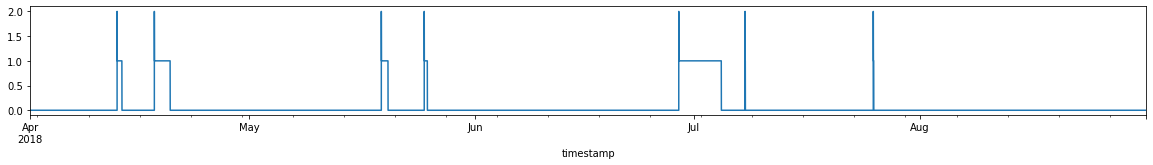

In [13]:
y_data.map({'NORMAL': 0, 'RECOVERING': 1, 'BROKEN': 2}).plot(figsize=(20, 2))
plt.show()

In [14]:
x_data = x_data.fillna(method='ffill').drop(columns='sensor_15')

In [15]:
x_data.index.max() - x_data.index.min()

Timedelta('152 days 23:59:00')

In [16]:
len(x_data), len(x_data) / 153

(220320, 1440.0)

In [17]:
print('Mean recovering time {:1f}'.format(y_data.eq('RECOVERING').sum() / y_data.eq('BROKEN').sum()))

Mean recovering time 2068.142857


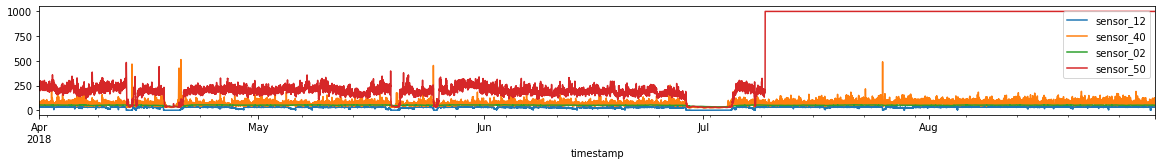

In [18]:
x_data.iloc[:, np.random.choice(x_data.shape[1], 4, replace=False)].plot(figsize=(20, 2))
plt.show()

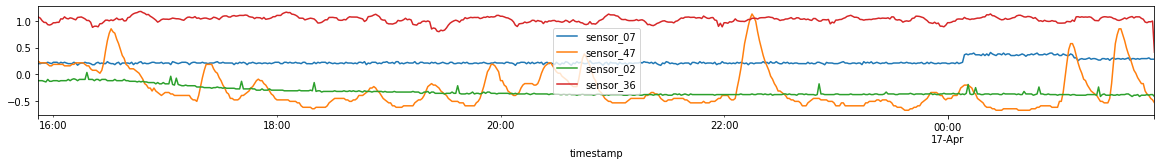

In [19]:
p = np.random.randint(0, 220320 - 120 * 5)
((x_data - x_data.mean()) / x_data.std()).clip(-5, 5) \
    .iloc[p : p + 120 * 5, np.random.choice(x_data.shape[1], 4, replace=False)].plot(figsize=(20, 2))
plt.show()

In [20]:
from sklearn.manifold import TSNE

In [21]:
from sklearn.decomposition import PCA

In [22]:
pca = PCA(n_components=2)
r_pca = pca.fit_transform(x_data.values)

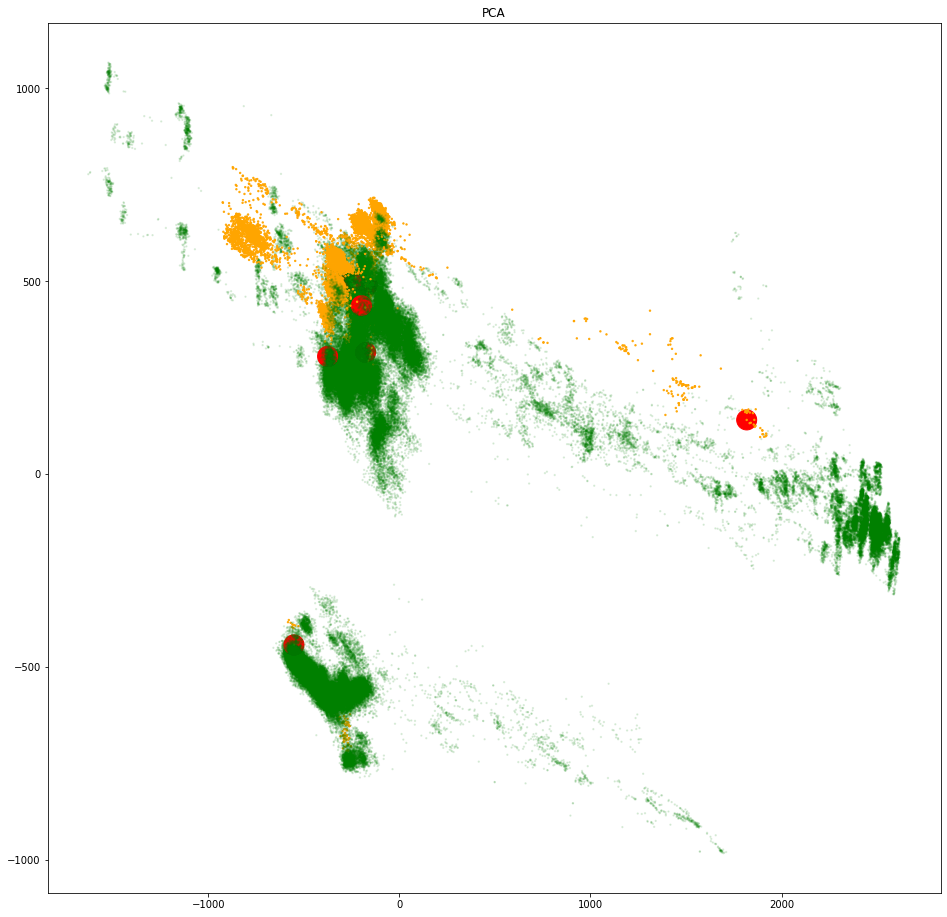

In [23]:
plt.figure(figsize=(16, 16))
plt.scatter(
    r_pca[:, 0], r_pca[:, 1],
    c=y_data.map({'NORMAL': 'green', 'RECOVERING': 'orange', 'BROKEN': 'red'}).values,
    s=y_data.map({'NORMAL': 2, 'RECOVERING': 2, 'BROKEN': 400}).values,
    alpha=y_data.map({'NORMAL': 0.1, 'RECOVERING': 0.9, 'BROKEN': 1.0}).values,
)
plt.title('PCA')
plt.show()

In [24]:
# tsne = TSNE(n_components=2, verbose=2)
# r_tsne = tsne.fit_transform(PCA(4).fit_transform(x_data.values))

In [25]:
# plt.figure(figsize=(16, 16))
# plt.scatter(
#     r_tsne[:, 0], r_tsne[:, 1],
#     c=y_data.map({'NORMAL': 'green', 'RECOVERING': 'orange', 'BROKEN': 'red'}).values,
#     s=y_data.map({'NORMAL': 2, 'RECOVERING': 2, 'BROKEN': 400}).values,
#     alpha=y_data.map({'NORMAL': 0.1, 'RECOVERING': 0.9, 'BROKEN': 1.0}).values,
# )
# plt.title('TSNE')
# plt.show()

In [26]:
!rm -r lightning_logs/

In [27]:
import torch
import pytorch_lightning as pl

In [28]:
import dltranz.lightning_modules.stream_encoder as se

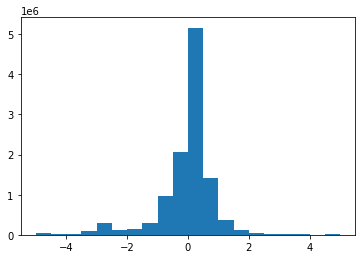

In [29]:
plt.hist(((x_data - x_data.mean()) / x_data.std()).values.flatten().clip(-5, 5), bins=20)
plt.show()

In [30]:
1440 // 2

720

In [31]:
1440 // 24

60

In [32]:
class TSwapChannels(torch.nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

In [54]:
stream_encoder = se.StreamEncoder(
    encoder_x2z=torch.nn.Sequential(
        se.TBatchNorm(x_data.shape[1]),
        se.ClipRange((-5, 5)),
        se.TDropout(0.0),
        TSwapChannels(),
        torch.nn.Conv1d(
            in_channels=x_data.shape[1], out_channels=32,
            kernel_size=12, stride=12, padding=0,
        ),
        torch.nn.ReLU(),
        torch.nn.Conv1d(
            in_channels=32, out_channels=16,
            kernel_size=5, stride=5, padding=0,
        ), 
        TSwapChannels(),
    ),
#     history_size=1440 * 3, predict_range=[0, 1, 2, 4, 8, 16, 32, 64, 720],
    history_size=48, predict_range=list(range(12)),
    z_channels=16, c_channels=32,
    var_gamma_z=0.5, var_gamma_c=0.3,
    lr=0.0001, weight_decay=0.0001,
    step_size=10, gamma=0.9,
    cpc_w=0.2, cov_z_w=1.0, var_z_w=1.0, cov_c_w=1.0, var_c_w=1.0,
)

```
####_####_####_####_####_####_####_####_####_####_####_####_####_####_####_####_####_####_####_####_
___________||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||___________
           |            |            |            |            |            |            

```

In [34]:
# l3dt = se.Loader3DTensor(stream_encoder)
# train_dl = l3dt.get_train_dataloader(torch.from_numpy(x_data.values).unsqueeze(0).float(), 32, 8)
# valid_dl = l3dt.get_valid_dataloader(torch.from_numpy(x_data.values).unsqueeze(0).float(), 512, 0)

In [35]:
from tqdm import tqdm

In [36]:
data = torch.from_numpy(x_data.values[:len(x_data) // 2]).unsqueeze(0).float()

In [37]:
B, T, C = data.size()
sample_len = stream_encoder.hparams.history_size + max(stream_encoder.hparams.predict_range) + 1
sample_len = ((sample_len + 1) * 12 + 1) * 5

In [38]:
ix = torch.arange(T - sample_len).view(-1, 1) + torch.arange(sample_len).view(1, -1)

In [39]:
ix.shape

torch.Size([106495, 3665])

In [40]:
all_batches = data[0, ix.view(-1)].view(*ix.size(), -1)

In [55]:
dl_train = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(all_batches),
    shuffle=True,
    batch_size=64,
    persistent_workers=True,
    num_workers=8,
)

In [56]:
dl_valid = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(x_data.values[len(x_data) // 2:]).unsqueeze(0).float()),
    batch_size=512,
    num_workers=0,
)

In [51]:
print(len(dl_train), len(dl_valid))
print(next(iter(dl_train))[0].shape, next(iter(dl_valid))[0].shape)

1664 1
torch.Size([64, 3665, 51]) torch.Size([1, 110160, 51])


In [57]:
trainer = pl.Trainer(
    gpus=[3],
    max_epochs=20,
    log_every_n_steps=10,
    progress_bar_refresh_rate=50, weights_summary=None,
    logger=pl.loggers.TensorBoardLogger(
        save_dir='lightning_logs/',
        default_hp_metric=False,
    )
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [58]:
trainer.fit(stream_encoder, train_dataloader=dl_train, val_dataloaders=dl_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]